# 영화 추천 시스템
1. Demographic Filtering : 인구 통계학적 필터링
    - 인기도를 반영하는 `수치, 공식`으로 접근


2. Content Based Filtering : 컨텐츠 기반 필터링
    - 특정 아이템과 유사한 아이템 추천
    - 1) `overview`를 통해 `Cosine Similarity`(실제론 `linear_kernel` 사용)를 구함
    - 2) `여러 키워드`를 이용
        - `literal_eval` : str 속 리스트의 형태를 이용할 수 있는 자료구조로 빼준다.
        - 어떤 특성 내에 있는 여러 개의 특성을 뽑아내 하나의 특성으로 만든 뒤(소문자화, 띄어쓰기 제거)
        - 1)과 유사하게 `Cosine Similarity`를 계산.

        
3. Collaborative Filtering : 협업 필터링
    - 비슷한 취향의 사람들을 매칭
    - 아이템 기반의 매칭이 아닌, 다른 사람의 좋아하는 분야와 겹친다면 추천해주는 방식임
    - `Surprise` 패키지 이용 : 설치가 되지 않아서 코드만 적어둠

In [3]:
import pandas as pd
import numpy as np

In [80]:
df1 = pd.read_csv('data/tmdb_5000_credits.csv')
df2 = pd.read_csv('data/tmdb_5000_movies.csv')

In [81]:
df1.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [82]:
df2.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466


In [83]:
df1.shape, df2.shape

((4803, 4), (4803, 20))

## 두 데이터셋의 row 수가 동일함
- merge를 진행해준다

In [84]:
# 두 column이 같은지 확인하는 메소드 : equals()
df1['title'].equals(df2['title'])

True

In [85]:
# Title을 없애고 movie_id와 id에 대해 join을 해줌
df1.columns

Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')

In [86]:
df1.columns = ['id', 'title', 'cast', 'crew']

In [87]:
df1[['id', 'cast', 'crew']]

,id,cast,crew
0,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
...,...,...,...
4798,9367,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de..."
4799,72766,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de..."
4800,231617,"[{""cast_id"": 8, ""character"": ""Oliver O\u2019To...","[{""credit_id"": ""52fe4df3c3a36847f8275ecf"", ""de..."
4801,126186,"[{""cast_id"": 3, ""character"": ""Sam"", ""credit_id...","[{""credit_id"": ""52fe4ad9c3a368484e16a36b"", ""de..."


In [88]:
df2 = df2.merge(df1[['id', 'cast', 'crew']], on = 'id')
df2.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


# 1. 인구통계학적 필터링
- 많은 사람이 평가한 평점의 신뢰도가 더 높다
    - 따라서 평점을 그대로 쓰지 않고, IMDB에서 가중치를 적용하는 식을 이용한다
- https://image.ibb.co/jYWZp9/wr.png
    - v : vote 수
    - m : 차트에 올라가기 위한 최소 vote 수
    - R : 평점
    - C : 전체 평점의 평균(VoteAverage 전체)

## Score 특성 만들고 출력

In [21]:
# 파라미터들
C = df2['vote_average'].mean()
m = df2['vote_count'].quantile(0.9) # 상위 10%의 데이터를 뽑음
print(C, m) # 1838개 이상의 평가가 있는 데이터를 이용

6.092171559442016 1838.4000000000015


In [22]:
q_movies = df2.copy().loc[df2['vote_count'] >= m] 
q_movies.shape

(481, 24)

In [23]:
q_movies['vote_count'].sort_values()

2585     1840
195      1851
2454     1859
597      1862
1405     1864
        ...  
788     10995
16      11776
0       11800
65      12002
96      13752
Name: vote_count, Length: 481, dtype: int64

In [24]:
# IMDB에서 제공하는 공식
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v / (v + m) * R) + (m / (m + v) * C)

In [25]:
q_movies['score'] = q_movies.apply(weighted_rating, axis = 1) # 각 row에 함수 인자를 적용해 column을 만듦
q_movies.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,status,tagline,title,vote_average,vote_count,cast_x,crew_x,cast_y,crew_y,score
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",7.050669
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",6.665696
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",6.239396


In [28]:
q_movies = q_movies.sort_values('score', ascending = False)
q_movies[['title', 'vote_average', 'vote_count', 'score']].head(10)

,title,vote_average,vote_count,score
1881,The Shawshank Redemption,8.5,8205,8.059258
662,Fight Club,8.3,9413,7.939256
65,The Dark Knight,8.2,12002,7.920020
3232,Pulp Fiction,8.3,8428,7.904645
96,Inception,8.1,13752,7.863239
3337,The Godfather,8.4,5893,7.851236
95,Interstellar,8.1,10867,7.809479
809,Forrest Gump,8.2,7927,7.803188
329,The Lord of the Rings: The Return of the King,8.1,8064,7.727243
1990,The Empire Strikes Back,8.2,5879,7.697884


## 기존 특성 popularity와 비교

In [29]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\program files\python39\python.exe -m pip install --upgrade pip' command.


Text(0.5, 1.0, 'Popular Movies')

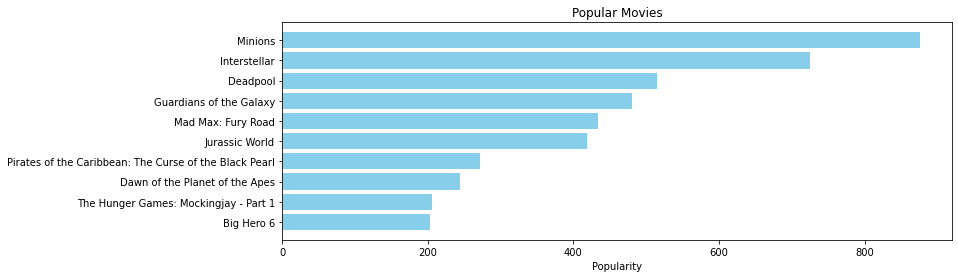

In [31]:
import matplotlib.pyplot as plt
pop = df2.sort_values('popularity', ascending = False)
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(10),pop['popularity'].head(10), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

- 직접 구한 스코어와 Popularity가 다른 이유
    - 1단위로 누적되는 변하는 데이터로 Popularity가 산정되기 때문(기준이 달라서)
    - [링크](https://developers.themoviedb.org/3/getting-started/popularity)
    ```
    Movies
    Number of votes for the day
    Number of views for the day
    Number of users who marked it as a "favourite" for the day
    Number of users who added it to their "watchlist" for the day
    Release date
    Number of total votes
    Previous days score
    ```

# 2. 컨텐츠 기반 필터링
- overview의 텍스트를 분석하여 유사한 컨텐츠를 찾아냄

### 1. Overview 기반

In [32]:
df2['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

### Bag of Words(BoW)
```
문장 1 : I am a boy
문장 2 : I am a girl
->
I(2), am(2), a(2), boy(1), girl(1)
->       I    am    a   boy    girl
문장 1 :  1     1    1    1       0 (1,1,1,1,0)
문장 2 :  1     1    1    0       1 (1,1,1,0,1)
```
- Feature Vectorize

- 문서 100개, 모든 문서에서 나온 단어가 1만개라면
    - Row를 문서, Column을 단어로 하는 2차원 array를 생각할 수 있음

1. `TfidfVectorizer` : TF-IDF 기반의 벡터화
    - TF-IDF : 많이 나오지만 중요하지 않은 단어들의 중요도를 줄여줌
        - 모든 문서에서 단어가 나온다면 그렇게 중요한 단어가 아님
        - 특정 문서에서만 나오는 단어라면 중요한 단어
2. `CountVectorizer` : 모든 단어

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words = 'english') # 불용어사전
# from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
# ENGLISH_STOP_WORDS

In [36]:
# 결측치 처리
df2['overview'].isnull().values.any() # 'overview'에 null값이 있다면 True 반환

True

In [37]:
df2['overview'] = df2['overview'].fillna('')
tfidf_matrix = tfidf.fit_transform(df2['overview']) 
tfidf_matrix.shape #(4803, 20978) : 20978개의 단어로 이루어짐

(4803, 20978)

In [38]:
tfidf_matrix # ... with 125840 stored elements in Compressed Sparse Row format : 125840개의 0이 아닌 데이터가 있다

<4803x20978 sparse matrix of type '<class 'numpy.float64'>'
	with 125840 stored elements in Compressed Sparse Row format>

### Cosine Similarity (코사인 유사도)
- `linear_kernel`이 속도가 더 빨라서 이를 이용함
- `TfidfVectorizer`를 통해 정규화했기 때문에 두 행렬을 내적하면 유사도를 구할 수 있다

In [39]:
from sklearn.metrics.pairwise import linear_kernel 

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.02160533, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.01488159, 0.        ,
        0.        ],
       ...,
       [0.        , 0.02160533, 0.01488159, ..., 1.        , 0.01609091,
        0.00701914],
       [0.        , 0.        , 0.        , ..., 0.01609091, 1.        ,
        0.01171696],
       [0.        , 0.        , 0.        , ..., 0.00701914, 0.01171696,
        1.        ]])

In [40]:
cosine_sim.shape # a dot a^T = (a,b) dot (b, a) = (a, a)

(4803, 4803)

- 이렇게 구한 행렬은 i=j를 기준으로 대칭
- 값이 1에 가까울수록 유사도가 높음

In [41]:
indices = pd.Series(df2.index, index = df2['title']).drop_duplicates()
indices

title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

In [46]:
df2.iloc[[3]]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,spoken_languages,status,tagline,title,vote_average,vote_count,cast_x,crew_x,cast_y,crew_y
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.31295,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."


In [61]:
# 영화의 제목 입력 -> 코사인 유사도 -> 가장 유사한 상위 10개의 항목을 반환하는 함수
def get_recommendations(title, cosine_sim = cosine_sim):
    
    # 1. 타이틀을 넣으면 인덱스를 반환
    test_index = indices[title]

    # 2. cosine_sim 에서 idx에 해당하는 데이터를 (idx, 유사도) 형태로 얻기 & 정렬, 상위 10개 영화 슬라이싱
    sim_scores = list(enumerate(cosine_sim[test_index]))
    sim_scores = sorted(sim_scores, key=lambda x : x[1], # 람다식을 넣으면 되는구나
                            reverse = True) # 내림차순 
    sim_scores = sim_scores[1:11] # 유사도가 가장 큰 건 자기 자신이므로 0은 제외

    # 3. 인덱스 정보 추출
    movie_indices = [i[0] for i in sim_scores]

    # 4. 영화 제목 얻기
    return df2['title'].iloc[movie_indices], sim_scores

In [57]:
# 유사도 상위 10개 데이터 추출 & 10개 정렬
test_sim_scores = list(enumerate(cosine_sim[3]))
test_sim_scores = sorted(test_sim_scores, key = lambda x : x[1], reverse = True)
test_sim_scores[1:11]

[(65, 0.30151176591665485),
 (299, 0.29857045255396825),
 (428, 0.2878505467001694),
 (1359, 0.264460923827995),
 (3854, 0.18545003006561456),
 (119, 0.16799626199850706),
 (2507, 0.16682891043358278),
 (9, 0.1337400906655523),
 (1181, 0.13219702138476813),
 (210, 0.13045537014449818)]

In [58]:
# 추천목록 상위 10개의 인덱스 정보 추출
test_movies_indices = [i[0] for i in test_sim_scores[1:11]]
test_movies_indices

[65, 299, 428, 1359, 3854, 119, 2507, 9, 1181, 210]

In [64]:
title, scores = get_recommendations('Spider-Man 3', cosine_sim = cosine_sim)

159                   Spider-Man
30                  Spider-Man 2
1534               Arachnophobia
20        The Amazing Spider-Man
38      The Amazing Spider-Man 2
1318                   The Thing
4664                     Bronson
3610           Not Easily Broken
4456       Raising Victor Vargas
4276                   Def-Con 4
Name: title, dtype: object
[(159, 0.28269377551691705), (30, 0.2464720918482627), (1534, 0.23671046045214342), (20, 0.22284657494531743), (38, 0.21139629084201764), (1318, 0.17166864148468533), (4664, 0.10119023772910762), (3610, 0.09698331013627293), (4456, 0.0944122894618133), (4276, 0.09420458163538704)]


In [66]:
title, scores = get_recommendations('Guardians of the Galaxy', cosine_sim = cosine_sim)
print(title)

3150                  Heavy Metal
38       The Amazing Spider-Man 2
3649                Lovely, Still
2262                          CJ7
1572    Forgetting Sarah Marshall
2900      Space Battleship Yamato
1824         The Face of an Angel
20         The Amazing Spider-Man
193                   After Earth
1115           The Sweetest Thing
Name: title, dtype: object


### 2. 다양한 요소 기반(장르, 감독, 키워드)

In [113]:
# df2 초기화
df1 = pd.read_csv('data/tmdb_5000_credits.csv')
df2 = pd.read_csv('data/tmdb_5000_movies.csv')

df1.columns = ['id', 'title', 'cast', 'crew']

df2 = df2.merge(df1[['id', 'cast', 'crew']], on = 'id')

In [114]:
df2.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [115]:
df2.loc[0, 'genres']

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

#### literal_eval
- 데이터 속의 string을 실제 데이터로 바꿔주는 역할

In [116]:
s1 = [{"id" : 28, "name" : "Action"}] # list
s2 = '[{"id" : 28, "name" : "Action"}]' # str

In [117]:
from ast import literal_eval
s2 = literal_eval(s2)
print(s2, type(s2))

[{'id': 28, 'name': 'Action'}] <class 'list'>


In [118]:
features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(literal_eval)

In [119]:
df2.loc[0, 'crew']

[{'credit_id': '52fe48009251416c750aca23',
  'department': 'Editing',
  'gender': 0,
  'id': 1721,
  'job': 'Editor',
  'name': 'Stephen E. Rivkin'},
 {'credit_id': '539c47ecc3a36810e3001f87',
  'department': 'Art',
  'gender': 2,
  'id': 496,
  'job': 'Production Design',
  'name': 'Rick Carter'},
 {'credit_id': '54491c89c3a3680fb4001cf7',
  'department': 'Sound',
  'gender': 0,
  'id': 900,
  'job': 'Sound Designer',
  'name': 'Christopher Boyes'},
 {'credit_id': '54491cb70e0a267480001bd0',
  'department': 'Sound',
  'gender': 0,
  'id': 900,
  'job': 'Supervising Sound Editor',
  'name': 'Christopher Boyes'},
 {'credit_id': '539c4a4cc3a36810c9002101',
  'department': 'Production',
  'gender': 1,
  'id': 1262,
  'job': 'Casting',
  'name': 'Mali Finn'},
 {'credit_id': '5544ee3b925141499f0008fc',
  'department': 'Sound',
  'gender': 2,
  'id': 1729,
  'job': 'Original Music Composer',
  'name': 'James Horner'},
 {'credit_id': '52fe48009251416c750ac9c3',
  'department': 'Directing',
  

In [120]:
# 감독 이름 빼내기
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']

    return np.nan # 없다면 nan 값 처리

In [121]:
df2['director'] = df2['crew'].apply(get_director)
df2['director']

0           James Cameron
1          Gore Verbinski
2              Sam Mendes
3       Christopher Nolan
4          Andrew Stanton
              ...        
4798     Robert Rodriguez
4799         Edward Burns
4800          Scott Smith
4801          Daniel Hsia
4802     Brian Herzlinger
Name: director, Length: 4803, dtype: object

In [122]:
# 결측값 확인
df2[df2['director'].isnull()].shape[0]

30

In [123]:
# 출연 배우
df2.loc[0, 'cast'][0:3]

[{'cast_id': 242,
  'character': 'Jake Sully',
  'credit_id': '5602a8a7c3a3685532001c9a',
  'gender': 2,
  'id': 65731,
  'name': 'Sam Worthington',
  'order': 0},
 {'cast_id': 3,
  'character': 'Neytiri',
  'credit_id': '52fe48009251416c750ac9cb',
  'gender': 1,
  'id': 8691,
  'name': 'Zoe Saldana',
  'order': 1},
 {'cast_id': 25,
  'character': 'Dr. Grace Augustine',
  'credit_id': '52fe48009251416c750aca39',
  'gender': 1,
  'id': 10205,
  'name': 'Sigourney Weaver',
  'order': 2}]

In [124]:
df2.loc[0, 'genres']

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [125]:
df2.loc[0, 'keywords'][0:3]

[{'id': 1463, 'name': 'culture clash'},
 {'id': 2964, 'name': 'future'},
 {'id': 3386, 'name': 'space war'}]

In [126]:
def get_list(x):
    "상위 3개의 데이터 중 name에 해당하는 value만 추출"
    if isinstance(x, list): # x가 리스트가 맞다면
        names = [i['name'] for i in x]
        if len(names) > 3:
            names = names[:3]
        return names

    # 예상 못한 데이터
    return []

In [127]:
features = ['cast', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(get_list)

In [128]:
df2[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [129]:
# 모든 데이터 소문자 변환, 띄어쓰기 제거
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(' ', '')) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(' ', ''))
        else:
            return '' 

In [130]:
features = ['cast', 'keywords', 'director', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(clean_data)

In [131]:
df2[['title', 'cast', 'keywords', 'genres']].head(5)

,title,cast,keywords,genres
0,Avatar,"[samworthington, zoesaldana, sigourneyweaver]","[cultureclash, future, spacewar]","[action, adventure, fantasy]"
1,Pirates of the Caribbean: At World's End,"[johnnydepp, orlandobloom, keiraknightley]","[ocean, drugabuse, exoticisland]","[adventure, fantasy, action]"
2,Spectre,"[danielcraig, christophwaltz, léaseydoux]","[spy, basedonnovel, secretagent]","[action, adventure, crime]"
3,The Dark Knight Rises,"[christianbale, michaelcaine, garyoldman]","[dccomics, crimefighter, terrorist]","[action, crime, drama]"
4,John Carter,"[taylorkitsch, lynncollins, samanthamorton]","[basedonnovel, mars, medallion]","[action, adventure, sciencefiction]"


In [132]:
# 위 column들을 통합한 soup라는 특성을 하나 더 만듦
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df2['soup'] = df2.apply(create_soup, axis=1)

In [133]:
print(df2['soup'])

0       cultureclash future spacewar samworthington zo...
1       ocean drugabuse exoticisland johnnydepp orland...
2       spy basedonnovel secretagent danielcraig chris...
3       dccomics crimefighter terrorist christianbale ...
4       basedonnovel mars medallion taylorkitsch lynnc...
                              ...                        
4798    unitedstates–mexicobarrier legs arms carlosgal...
4799     edwardburns kerrybishé marshadietlein edwardb...
4800    date loveatfirstsight narration ericmabius kri...
4801       danielhenney elizacoupe billpaxton danielhsia 
4802    obsession camcorder crush drewbarrymore brianh...
Name: soup, Length: 4803, dtype: object


In [134]:
df2['overview']

0       In the 22nd century, a paraplegic Marine is di...
1       Captain Barbossa, long believed to be dead, ha...
2       A cryptic message from Bond’s past sends him o...
3       Following the death of District Attorney Harve...
4       John Carter is a war-weary, former military ca...
                              ...                        
4798    El Mariachi just wants to play his guitar and ...
4799    A newlywed couple's honeymoon is upended by th...
4800    "Signed, Sealed, Delivered" introduces a dedic...
4801    When ambitious New York attorney Sam is sent t...
4802    Ever since the second grade when he first saw ...
Name: overview, Length: 4803, dtype: object

### Soup Vectorize
- `CountVectorize` : 관형사 같은 게 없고 모든 단어가 적절한 의미를 지녔기 떄문

In [135]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words = 'english')
count_matrix = count.fit_transform(df2['soup'])
count_matrix

<4803x11520 sparse matrix of type '<class 'numpy.int64'>'
	with 42935 stored elements in Compressed Sparse Row format>

In [136]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)
cosine_sim2

array([[1. , 0.3, 0.2, ..., 0. , 0. , 0. ],
       [0.3, 1. , 0.2, ..., 0. , 0. , 0. ],
       [0.2, 0.2, 1. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 1. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 1. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 1. ]])

In [137]:
indices['Avatar']

0

In [138]:
# 없어도 되는 코드이나 캐글과 싱크를 맞춤
df2 = df2.reset_index()
indices = pd.Series(df2.index, index = df2['title'])
indices

title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

In [139]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

(65               The Dark Knight
 119                Batman Begins
 4638    Amidst the Devil's Wings
 1196                The Prestige
 3073           Romeo Is Bleeding
 3326              Black November
 1503                      Takers
 1986                      Faster
 303                     Catwoman
 747               Gangster Squad
 Name: title, dtype: object,
 [(65, 0.7),
  (119, 0.7),
  (4638, 0.5477225575051663),
  (1196, 0.4),
  (3073, 0.4),
  (3326, 0.3585685828003181),
  (1503, 0.33541019662496846),
  (1986, 0.33541019662496846),
  (303, 0.31622776601683794),
  (747, 0.31622776601683794)])

In [140]:
get_recommendations('Up', cosine_sim2)


(231                                        Monsters, Inc.
 1983                                     Meet the Deedles
 3403    Alpha and Omega: The Legend of the Saw Tooth Cave
 3114                                          Elsa & Fred
 1580                                          The Nut Job
 3670                                      Running Forever
 4709                            A Charlie Brown Christmas
 40                                                 Cars 2
 42                                            Toy Story 3
 77                                             Inside Out
 Name: title, dtype: object,
 [(231, 0.4),
  (1983, 0.3585685828003181),
  (3403, 0.3585685828003181),
  (3114, 0.33541019662496846),
  (1580, 0.31622776601683794),
  (3670, 0.31622776601683794),
  (4709, 0.31622776601683794),
  (40, 0.30000000000000004),
  (42, 0.30000000000000004),
  (77, 0.30000000000000004)])

In [141]:
get_recommendations('The Martian', cosine_sim2)


(4                    John Carter
 95                  Interstellar
 365                      Contact
 256                    Allegiant
 1326                The 5th Wave
 1958                 On the Road
 3043            End of the Spear
 3373    The Other Side of Heaven
 3392                       Gerry
 3698                   Moby Dick
 Name: title, dtype: object,
 [(4, 0.4),
  (95, 0.4),
  (365, 0.4),
  (256, 0.31622776601683794),
  (1326, 0.31622776601683794),
  (1958, 0.31622776601683794),
  (3043, 0.31622776601683794),
  (3373, 0.31622776601683794),
  (3392, 0.31622776601683794),
  (3698, 0.31622776601683794)])

In [142]:
df2.loc[4]

index                                                                   4
budget                                                          260000000
genres                                [action, adventure, sciencefiction]
homepage                             http://movies.disney.com/john-carter
id                                                                  49529
keywords                                  [basedonnovel, mars, medallion]
original_language                                                      en
original_title                                                John Carter
overview                John Carter is a war-weary, former military ca...
popularity                                                      43.926995
production_companies          [{"name": "Walt Disney Pictures", "id": 2}]
production_countries    [{"iso_3166_1": "US", "name": "United States o...
release_date                                                   2012-03-07
revenue                               

In [143]:
get_recommendations('The Avengers', cosine_sim2)

(7                  Avengers: Age of Ultron
 26              Captain America: Civil War
 79                              Iron Man 2
 169     Captain America: The First Avenger
 174                    The Incredible Hulk
 85     Captain America: The Winter Soldier
 31                              Iron Man 3
 33                   X-Men: The Last Stand
 68                                Iron Man
 94                 Guardians of the Galaxy
 Name: title, dtype: object,
 [(7, 0.7),
  (26, 0.6),
  (79, 0.5),
  (169, 0.5),
  (174, 0.5),
  (85, 0.4767312946227962),
  (31, 0.4),
  (33, 0.4),
  (68, 0.4),
  (94, 0.4)])

## 위 함수를 웹사이트로 구현

In [144]:
import pickle
df2.head(3) # id, title 정도만 저장

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director,soup
0,0,237000000,"[action, adventure, fantasy]",http://www.avatarmovie.com/,19995,"[cultureclash, future, spacewar]",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[samworthington, zoesaldana, sigourneyweaver]","[{'credit_id': '52fe48009251416c750aca23', 'de...",jamescameron,cultureclash future spacewar samworthington zo...
1,1,300000000,"[adventure, fantasy, action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drugabuse, exoticisland]",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[johnnydepp, orlandobloom, keiraknightley]","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",goreverbinski,ocean drugabuse exoticisland johnnydepp orland...
2,2,245000000,"[action, adventure, crime]",http://www.sonypictures.com/movies/spectre/,206647,"[spy, basedonnovel, secretagent]",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[danielcraig, christophwaltz, léaseydoux]","[{'credit_id': '54805967c3a36829b5002c41', 'de...",sammendes,spy basedonnovel secretagent danielcraig chris...


In [145]:
movies = df2[['id', 'title']].copy()
movies.head()

,id,title
0,19995,Avatar
1,285,Pirates of the Caribbean: At World's End
2,206647,Spectre
3,49026,The Dark Knight Rises
4,49529,John Carter


In [146]:
pickle.dump(movies, open('movies.pickle', 'wb'))

In [148]:
# cos 유사도 데이터
pickle.dump(cosine_sim2, open('cosine_sim.pickle', 'wb'))

# 웹사이트 구현
- `streamlit` : 데이터 사이언스 관련 웹사이트를 구현할 때 매우매우 편리합니다.
- `app.py` 참조

# 3. Collaborative Filtering 
- `Surprise` 패키지가 설치되지 않는 문제가 있어서 코드만 적어놓고 마무리함

In [1]:
import pandas as pd
# from surprise import Reader, Dataset, SVD
# from surprise.model_selection import cross_validate

In [2]:
ratings = pd.read_csv('data/ratings_small.csv')
ratings.head()


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


- Reader Class

In [3]:
ratings['rating'].min()
ratings['rating'].max()

5.0

In [ ]:
reader = Reader(rating_scale = (0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader = reader) # 반드시 3개의 Column을 갖고 있어야 함
data

In [ ]:
svd = SVD(random_state = 0)

In [ ]:
# evaluate는 더 이상 지원되지 않음
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv = 5, verbose = True)
# RMSE, MAE, fit time, test time

In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
ratings[ratings['userid'] == 1]
svd.predict(1, 302, 3) # user id 1이 영화 id 302를 실제로 3점이라고 평가했음, est = 모델이 추측한 평가 값

In [ ]:
ratings[ratings['userid'] == 100]
svd.predict(100, 1029) # userid = 100인 사람이 movieid = 1029 평가 예측 값